## ParFlow-CLM Water Balance Exercise
This notebook runs a ParFlow-CLM simulation and loads data to compare the fluxes calculated in CLM to the vector passed to ParFlow.  It covers some basics of model coupling and LSM processes.

### Goal
The goal of this exercise is to understand the setup and simulation results of a fully coupled ParFlow-CLM run. Processes included in this exercise are water redistriubtion in the variably saturated subsurface with overland flow at the surface and coupling with land surface processes related to evaporation, transpiration (root water uptake by plants) and infiltration (precipitation minus evaporation). A water balance illustrates the results.  

### Run ParFlow-CLM for 24 hours
The first cell of this notebook runs a single-column PF-CLM for a day, saving the output for analysis below.

### ParFlow-CLM water balance
The next cell in this notebook conducts a water balance with CLM output variables and the `EvapTrans` vector output by ParFlow.  This vector is an output of what CLM passes to ParFlow every timestep and can be used for diagnostics.  This vector can be used (as we did in earlier notebooks) to conduct a water balance of ParFlow but in this case we are just comparing the CLM output variables to the `EvapTrans` vector.   

In [44]:
# Import the ParFlow package
#
from parflow import Run
import os
import shutil
from parflow.tools.fs import mkdir, cp, chdir, get_absolute_path, rm, exists

print(os.getcwd())
relative_path_to_runfolder = 'output_water_balance'
base = get_absolute_path(relative_path_to_runfolder)
mkdir(base)
print(base)

# copy CLM files
cp('inputs/drv_clmin.dat', 'output_water_balance/drv_clmin.dat')
cp('inputs/drv_vegm.dat', 'output_water_balance/drv_vegm.dat')
cp('inputs/drv_vegp.dat', 'output_water_balance/drv_vegp.dat')

alpha_vG = 2 #Set alpha for vanGenuchten model
head_table = -10 #location of water table [m]
simulation_type = 'same_head' #'same_head'  #Simulations type: same_head vs same_saturation vs vegpvegm


# Set our Run Name 
PFCLM_SC = Run("PFCLM_SC")


stopt = 8760
## run only for 24 hours for the water balance example
#stopt = 24

#-----------------------------------------------------------------------------
# File input version number
#-----------------------------------------------------------------------------
PFCLM_SC.FileVersion = 4

#-----------------------------------------------------------------------------
# Process Topology
#-----------------------------------------------------------------------------

PFCLM_SC.Process.Topology.P = 1
PFCLM_SC.Process.Topology.Q = 1
PFCLM_SC.Process.Topology.R = 1

#-----------------------------------------------------------------------------
# Computational Grid
#-----------------------------------------------------------------------------
PFCLM_SC.ComputationalGrid.Lower.X = 0.0
PFCLM_SC.ComputationalGrid.Lower.Y = 0.0
PFCLM_SC.ComputationalGrid.Lower.Z = 0.0

PFCLM_SC.ComputationalGrid.DX      = 2.0
PFCLM_SC.ComputationalGrid.DY      = 2.0
PFCLM_SC.ComputationalGrid.DZ      = 0.1

PFCLM_SC.ComputationalGrid.NX      = 1
PFCLM_SC.ComputationalGrid.NY      = 1
PFCLM_SC.ComputationalGrid.NZ      = 20

#-----------------------------------------------------------------------------
# The Names of the GeomInputs
#-----------------------------------------------------------------------------
PFCLM_SC.GeomInput.Names = 'domain_input'

#-----------------------------------------------------------------------------
# Domain Geometry Input
#-----------------------------------------------------------------------------
PFCLM_SC.GeomInput.domain_input.InputType = 'Box'
PFCLM_SC.GeomInput.domain_input.GeomName  = 'domain'

#-----------------------------------------------------------------------------
# Domain Geometry
#-----------------------------------------------------------------------------
PFCLM_SC.Geom.domain.Lower.X = 0.0
PFCLM_SC.Geom.domain.Lower.Y = 0.0
PFCLM_SC.Geom.domain.Lower.Z = 0.0

PFCLM_SC.Geom.domain.Upper.X = 2.0
PFCLM_SC.Geom.domain.Upper.Y = 2.0
PFCLM_SC.Geom.domain.Upper.Z = 2.0

PFCLM_SC.Geom.domain.Patches = 'x_lower x_upper y_lower y_upper z_lower z_upper'


#--------------------------------------------
# variable dz assignments
#------------------------------------------

PFCLM_SC.Solver.Nonlinear.VariableDz = True
PFCLM_SC.dzScale.GeomNames           = 'domain'
PFCLM_SC.dzScale.Type                = 'nzList'
PFCLM_SC.dzScale.nzListNumber        = 20

# cells start at the bottom (0) and moves up to the top
# domain is 3.21 m thick, root zone is down to 19 cells 
# so the root zone is 2.21 m thick
PFCLM_SC.Cell._0.dzScale.Value  = 10.0   # first cell is 10*0.1 1m thick
PFCLM_SC.Cell._1.dzScale.Value  = 5.0    # next cell is 5*0.1 50 cm thick
PFCLM_SC.Cell._2.dzScale.Value  = 1.0   
PFCLM_SC.Cell._3.dzScale.Value  = 1.0
PFCLM_SC.Cell._4.dzScale.Value  = 1.0
PFCLM_SC.Cell._5.dzScale.Value  = 1.0
PFCLM_SC.Cell._6.dzScale.Value  = 1.0
PFCLM_SC.Cell._7.dzScale.Value  = 1.0
PFCLM_SC.Cell._8.dzScale.Value  = 1.0
PFCLM_SC.Cell._9.dzScale.Value  = 1.0
PFCLM_SC.Cell._10.dzScale.Value = 1.0
PFCLM_SC.Cell._11.dzScale.Value = 1.0
PFCLM_SC.Cell._12.dzScale.Value = 1.0
PFCLM_SC.Cell._13.dzScale.Value = 1.0
PFCLM_SC.Cell._14.dzScale.Value = 1.0
PFCLM_SC.Cell._15.dzScale.Value = 1.0
PFCLM_SC.Cell._16.dzScale.Value = 1.0
PFCLM_SC.Cell._17.dzScale.Value = 1.0
PFCLM_SC.Cell._18.dzScale.Value = 1.0
PFCLM_SC.Cell._19.dzScale.Value = 0.1   #0.1* 0.1 = 0.01  1 cm top layer

#-----------------------------------------------------------------------------
# Perm
#-----------------------------------------------------------------------------
PFCLM_SC.Geom.Perm.Names              = 'domain'
PFCLM_SC.Geom.domain.Perm.Type        = 'Constant'
PFCLM_SC.Geom.domain.Perm.Value       = 0.001465
PFCLM_SC.Geom.domain.Perm.Value       = 0.1465

PFCLM_SC.Perm.TensorType              = 'TensorByGeom'
PFCLM_SC.Geom.Perm.TensorByGeom.Names = 'domain'
PFCLM_SC.Geom.domain.Perm.TensorValX  = 1.0
PFCLM_SC.Geom.domain.Perm.TensorValY  = 1.0
PFCLM_SC.Geom.domain.Perm.TensorValZ  = 1.0

#-----------------------------------------------------------------------------
# Specific Storage
#-----------------------------------------------------------------------------

PFCLM_SC.SpecificStorage.Type              = 'Constant'
PFCLM_SC.SpecificStorage.GeomNames         = 'domain'
PFCLM_SC.Geom.domain.SpecificStorage.Value = 1.0e-4

#-----------------------------------------------------------------------------
# Phases
#-----------------------------------------------------------------------------

PFCLM_SC.Phase.Names = 'water'

PFCLM_SC.Phase.water.Density.Type     = 'Constant'
PFCLM_SC.Phase.water.Density.Value    = 1.0

PFCLM_SC.Phase.water.Viscosity.Type   = 'Constant'
PFCLM_SC.Phase.water.Viscosity.Value  = 1.0

#-----------------------------------------------------------------------------
# Contaminants
#-----------------------------------------------------------------------------
PFCLM_SC.Contaminants.Names = ''


#-----------------------------------------------------------------------------
# Gravity
#-----------------------------------------------------------------------------

PFCLM_SC.Gravity = 1.0

#-----------------------------------------------------------------------------
# Setup timing info
#-----------------------------------------------------------------------------

PFCLM_SC.TimingInfo.BaseUnit     = 1.0
PFCLM_SC.TimingInfo.StartCount   = 0
PFCLM_SC.TimingInfo.StartTime    = 0.0
PFCLM_SC.TimingInfo.StopTime     = stopt
PFCLM_SC.TimingInfo.DumpInterval = 1.0
PFCLM_SC.TimeStep.Type           = 'Constant'
PFCLM_SC.TimeStep.Value          = 1.0


#-----------------------------------------------------------------------------
# Porosity
#-----------------------------------------------------------------------------

PFCLM_SC.Geom.Porosity.GeomNames    = 'domain'

PFCLM_SC.Geom.domain.Porosity.Type  = 'Constant'
PFCLM_SC.Geom.domain.Porosity.Value = 0.3

#-----------------------------------------------------------------------------
# Domain
#-----------------------------------------------------------------------------
PFCLM_SC.Domain.GeomName = 'domain'

#-----------------------------------------------------------------------------
# Mobility
#-----------------------------------------------------------------------------
PFCLM_SC.Phase.water.Mobility.Type  = 'Constant'
PFCLM_SC.Phase.water.Mobility.Value = 1.0

#-----------------------------------------------------------------------------
# Relative Permeability
#-----------------------------------------------------------------------------

PFCLM_SC.Phase.RelPerm.Type        = 'VanGenuchten'
PFCLM_SC.Phase.RelPerm.GeomNames   = 'domain'

PFCLM_SC.Geom.domain.RelPerm.Alpha = alpha_vG
PFCLM_SC.Geom.domain.RelPerm.N     = 2.0

#---------------------------------------------------------
# Saturation
#---------------------------------------------------------

PFCLM_SC.Phase.Saturation.Type        = 'VanGenuchten'
PFCLM_SC.Phase.Saturation.GeomNames   = 'domain'

PFCLM_SC.Geom.domain.Saturation.Alpha = alpha_vG
PFCLM_SC.Geom.domain.Saturation.N     = 3.0
PFCLM_SC.Geom.domain.Saturation.SRes  = 0.2
PFCLM_SC.Geom.domain.Saturation.SSat  = 1.0

#-----------------------------------------------------------------------------
# Wells
#-----------------------------------------------------------------------------
PFCLM_SC.Wells.Names = ''


#-----------------------------------------------------------------------------
# Time Cycles
#-----------------------------------------------------------------------------
PFCLM_SC.Cycle.Names = 'constant'
PFCLM_SC.Cycle.constant.Names = 'alltime'
PFCLM_SC.Cycle.constant.alltime.Length = 1
PFCLM_SC.Cycle.constant.Repeat = -1

#-----------------------------------------------------------------------------
# Boundary Conditions: Pressure
#-----------------------------------------------------------------------------
PFCLM_SC.BCPressure.PatchNames = 'x_lower x_upper y_lower y_upper z_lower z_upper'

PFCLM_SC.Patch.x_lower.BCPressure.Type          = 'FluxConst'
PFCLM_SC.Patch.x_lower.BCPressure.Cycle         = 'constant'
PFCLM_SC.Patch.x_lower.BCPressure.alltime.Value = 0.0

PFCLM_SC.Patch.y_lower.BCPressure.Type          = 'FluxConst'
PFCLM_SC.Patch.y_lower.BCPressure.Cycle         = 'constant'
PFCLM_SC.Patch.y_lower.BCPressure.alltime.Value = 0.0

#PFCLM_SC.Patch.z_lower.BCPressure.Type = 'FluxConst'
PFCLM_SC.Patch.z_lower.BCPressure.Type          = 'DirEquilRefPatch'
PFCLM_SC.Patch.z_lower.BCPressure.RefGeom       = 'domain'
PFCLM_SC.Patch.z_lower.BCPressure.RefPatch      = 'z_upper'
PFCLM_SC.Patch.z_lower.BCPressure.Cycle         = 'constant'
PFCLM_SC.Patch.z_lower.BCPressure.alltime.Value = head_table

PFCLM_SC.Patch.x_upper.BCPressure.Type          = 'FluxConst'
PFCLM_SC.Patch.x_upper.BCPressure.Cycle         = 'constant'
PFCLM_SC.Patch.x_upper.BCPressure.alltime.Value = 0.0

PFCLM_SC.Patch.y_upper.BCPressure.Type          = 'FluxConst'
PFCLM_SC.Patch.y_upper.BCPressure.Cycle         = 'constant'
PFCLM_SC.Patch.y_upper.BCPressure.alltime.Value = 0.0

PFCLM_SC.Patch.z_upper.BCPressure.Type          = 'OverlandFlow'
PFCLM_SC.Patch.z_upper.BCPressure.Cycle         = 'constant'
PFCLM_SC.Patch.z_upper.BCPressure.alltime.Value = 0.0

#---------------------------------------------------------
# Topo slopes in x-direction
#---------------------------------------------------------

PFCLM_SC.TopoSlopesX.Type              = 'Constant'
PFCLM_SC.TopoSlopesX.GeomNames         = 'domain'
PFCLM_SC.TopoSlopesX.Geom.domain.Value = 0.05

#---------------------------------------------------------
# Topo slopes in y-direction
#---------------------------------------------------------

PFCLM_SC.TopoSlopesY.Type              = 'Constant'
PFCLM_SC.TopoSlopesY.GeomNames         = 'domain'
PFCLM_SC.TopoSlopesY.Geom.domain.Value = 0.00

#---------------------------------------------------------
# Mannings coefficient
#---------------------------------------------------------

PFCLM_SC.Mannings.Type               = 'Constant'
PFCLM_SC.Mannings.GeomNames          = 'domain'
PFCLM_SC.Mannings.Geom.domain.Value  = 2.e-6

#-----------------------------------------------------------------------------
# Phase sources:
#-----------------------------------------------------------------------------

PFCLM_SC.PhaseSources.water.Type              = 'Constant'
PFCLM_SC.PhaseSources.water.GeomNames         = 'domain'
PFCLM_SC.PhaseSources.water.Geom.domain.Value = 0.0

#-----------------------------------------------------------------------------
# Exact solution specification for error calculations
#-----------------------------------------------------------------------------

PFCLM_SC.KnownSolution = 'NoKnownSolution'

#-----------------------------------------------------------------------------
# Set solver parameters
#-----------------------------------------------------------------------------

PFCLM_SC.Solver         = 'Richards'
PFCLM_SC.Solver.MaxIter = 9000

PFCLM_SC.Solver.Nonlinear.MaxIter           = 100
PFCLM_SC.Solver.Nonlinear.ResidualTol       = 1e-5
PFCLM_SC.Solver.Nonlinear.EtaChoice         = 'Walker1'
PFCLM_SC.Solver.Nonlinear.EtaValue          = 0.01
PFCLM_SC.Solver.Nonlinear.UseJacobian       = False
PFCLM_SC.Solver.Nonlinear.DerivativeEpsilon = 1e-12
PFCLM_SC.Solver.Nonlinear.StepTol           = 1e-30
PFCLM_SC.Solver.Nonlinear.Globalization     = 'LineSearch'
PFCLM_SC.Solver.Linear.KrylovDimension      = 100
PFCLM_SC.Solver.Linear.MaxRestarts          = 5
PFCLM_SC.Solver.Linear.Preconditioner       = 'PFMG'
PFCLM_SC.Solver.PrintSubsurf                = False
PFCLM_SC.Solver.Drop                        = 1E-20
PFCLM_SC.Solver.AbsTol                      = 1E-9

#Writing output options for ParFlow
write_pfb = True  #only PFB output for water balance example
#  PFB  no SILO
PFCLM_SC.Solver.PrintSubsurfData         = write_pfb
PFCLM_SC.Solver.PrintPressure            = write_pfb
PFCLM_SC.Solver.PrintSaturation          = write_pfb
PFCLM_SC.Solver.PrintCLM                 = write_pfb
PFCLM_SC.Solver.PrintMask                = write_pfb
PFCLM_SC.Solver.PrintSpecificStorage     = write_pfb
PFCLM_SC.Solver.PrintEvapTrans           = write_pfb

PFCLM_SC.Solver.WriteSiloMannings        = False
PFCLM_SC.Solver.WriteSiloMask            = False
PFCLM_SC.Solver.WriteSiloSlopes          = False
PFCLM_SC.Solver.WriteSiloSaturation      = False

#write output in NetCDF
write_netcdf = False
#PFCLM_SC.NetCDF.NumStepsPerFile          = 240
PFCLM_SC.NetCDF.WritePressure            = write_netcdf
PFCLM_SC.NetCDF.WriteSubsurface          = False
PFCLM_SC.NetCDF.WriteSaturation          = write_netcdf
PFCLM_SC.NetCDF.WriteCLM                 = write_netcdf
#PFCLM_SC.NetCDF.CLMNumStepsPerFile       = 240


#---------------------------------------------------
# LSM / CLM options
#---------------------------------------------------

# set LSM options to CLM
PFCLM_SC.Solver.LSM              = 'CLM'
# specify type of forcing, file name and location
PFCLM_SC.Solver.CLM.MetForcing   = '1D'
#PFCLM_SC.Solver.CLM.MetFileName = 'forcing_1.txt'
PFCLM_SC.Solver.CLM.MetFileName  = 'narr_1hr.txt'
#PFCLM_SC.Solver.CLM.MetFileName  = 'pumphouse_forcing_wy17_wy19.txt'
PFCLM_SC.Solver.CLM.MetFilePath  = '../forcing'

# Set CLM Plant Water Use Parameters
PFCLM_SC.Solver.CLM.EvapBeta       = 'Linear'
PFCLM_SC.Solver.CLM.VegWaterStress = 'Saturation'
PFCLM_SC.Solver.CLM.ResSat         = 0.2
PFCLM_SC.Solver.CLM.WiltingPoint   = 0.2
PFCLM_SC.Solver.CLM.FieldCapacity  = 1.00
PFCLM_SC.Solver.CLM.IrrigationType = 'none'
PFCLM_SC.Solver.CLM.RootZoneNZ     =  19
PFCLM_SC.Solver.CLM.SoiLayer       =  15

#Writing output options for CLM
#  no SILO, no native CLM logs
PFCLM_SC.Solver.PrintLSMSink        = False
PFCLM_SC.Solver.CLM.CLMDumpInterval = 1
PFCLM_SC.Solver.CLM.CLMFileDir      = 'output/'
PFCLM_SC.Solver.CLM.BinaryOutDir    = False
PFCLM_SC.Solver.CLM.IstepStart      = 1
PFCLM_SC.Solver.WriteCLMBinary      = False
PFCLM_SC.Solver.WriteSiloCLM        = False
PFCLM_SC.Solver.CLM.WriteLogs       = False
PFCLM_SC.Solver.CLM.WriteLastRST    = True
PFCLM_SC.Solver.CLM.DailyRST        = False
PFCLM_SC.Solver.CLM.SingleFile      = True
#PFCLM_SC.NetCDF.Compression         = True
#PFCLM_SC.NetCDF.ROMIOhints='romio.hints'
#PFCLM_SC.NetCDF.NodeLevelIO         = True

#---------------------------------------------------
# Initial conditions: water pressure
#---------------------------------------------------
if simulation_type == 'same_saturation':
    filename=f"ic_pressure_WTD{head_table}_alpha{alpha_vG}.pfb"
    print(filename)
    PFCLM_SC.ICPressure.Type                 = "PFBFile"
    PFCLM_SC.ICPressure.GeomNames            = 'domain'
    PFCLM_SC.Geom.domain.ICPressure.FileName = filename
else:
    PFCLM_SC.ICPressure.Type                 = 'HydroStaticPatch' #'Constant' 
    PFCLM_SC.ICPressure.GeomNames            = 'domain'
    PFCLM_SC.Geom.domain.ICPressure.Value    = head_table
    PFCLM_SC.Geom.domain.ICPressure.RefGeom  = 'domain'
    PFCLM_SC.Geom.domain.ICPressure.RefPatch = 'z_upper'

#-----------------------------------------------------------------------------
# Run ParFlow 
#-----------------------------------------------------------------------------
import time
start_= time.time()
PFCLM_SC.run(working_directory=base)
end_  = time.time()

print("The code takes", end_ - start_," seconds")


/home/ms6985/ParFlow-project/pfclm_sc
/home/ms6985/ParFlow-project/pfclm_sc/output_water_balance

# ==============================================================================
# ParFlow directory
#  - /home/SHARED/software/parflow/7c8e7f0
# ParFlow version
#  - 3.13.0
# Working directory
#  - /home/ms6985/ParFlow-project/pfclm_sc/output_water_balance
# ParFlow database
#  - PFCLM_SC.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully
# ==============================================================================

The code takes 246.82009506225586  seconds


In [45]:
## load PFCLM output and conduct a detailed water balance

import parflow as pf
import matplotlib.pyplot as plt
import numpy as np
from set_demo_defaults import *
import os
#import netCDF4 as nc
import xarray as xr
import time as timer
from parflow.tools.fs import get_absolute_path
from parflow.tools.io import write_pfb, read_pfb
from glob import glob
import pandas as pd
import parflow as pf
from pathlib import Path
from numpy import ones, kron

from parflow import Run
import parflow.tools.hydrology as hydro

path = ''
current_dir = os.getcwd()
print(current_dir)
relative_path_to_runfolder = 'output_water_balance'
path = current_dir+'/'+relative_path_to_runfolder
print(path)
 
path_forcing = current_dir+'/forcing'
print(path_forcing)

run_name = 'PFCLM_SC'
run = Run.from_definition(f'{path}/{run_name}.pfidb')
data = run.data_accessor
nx = data.shape[2]
ny = data.shape[1]
nz = data.shape[0]
dx = data.dx
dy = data.dy
dz = data.dz

# intialize data and time arrays
data    = np.zeros([8,8760])
time    = np.zeros([8760])

#CLM data array format 
# reading the CLM file PFCLM_SC.out.clm_output.<file number>.C.pfb
# variables are by layer:
# 0 eflx_lh_tot:  total latent heat flux (Wm-2)  
# 1 eflx_lwrad_out: total upward LW radiation (Wm-2)  
# 2 eflx_sh_tot: total sensible heat flux (Wm-2)  
# 3 eflx_soil_grnd: ground heat flux (Wm-2)    
# 4 qflx_evap_tot: net veg. evaporation and transpiration and soil evaporation (mms-1)  
# 5 qflx_evap_grnd: ground evaporation (mms-1)   
# 6 qflx_evap_soi: soil evaporation (mms-1)   
# 7 qflx_evap_veg: vegetation evaporation (canopy) and transpiration (mms-1)   
# 8 qflx_tran_veg: transpiration (mms-1)  
# 9 qflx_infl: infiltration flux (mms-1)   
# 10 swe_out: SWE (mm)   
# 11 t_grnd: ground temperature (K)  
# 12 irrigation flux
# 13 - 24 Soil temperature by layer (K)


#  assemble files to be loaded as an entire sequence
# then map specific variables to the data array which holds things for analysis
# and plotting

files = glob(path+"/PFCLM_SC.out.clm_output.*.C.pfb")
#print(files[0,10])
CLM_data = pf.read_pfb_sequence(files)

## create data frame for CLM output ET vars
clm_output = pd.DataFrame({'T [mm/s]':CLM_data[:,8,0,0],'Ebs [mm/s]':CLM_data[:,6,0,0],'Qflux infil [mm/s]':CLM_data[:,9,0,0],'Qflux irrig [mm/s]':CLM_data[:,12,0,0],'qflx_evap_grnd [mm/s]':CLM_data[:,5,0,0] })
## the variables we use here are chosen to represent the fluxes passed to ParFlow, detailed below

# ## load in the evaptrans output, this is constructed in the coupling between PF and CLM as follows:
# ## see [pf_couple.F90](https://github.com/parflow/parflow/blob/master/pfsimulator/clm/pf_couple.F90)
# ## looping over the columns, t, for a depth, k, the uppermost soil layer is assigned
# ## the infiltration flux (qflx_infl) + irrigation water applied - transpiration (qflx_tran_veg):
# #LINE 40: clm(t)%pf_flux(k)=(-clm(t)%qflx_tran_veg*clm(t)%rootfr(k)) + clm(t)%qflx_infl + clm(t)%qflx_qirr_inst(k)
# ## layers below this are assigned the transpiration X the root fraction.  
# ## Note that if there are errors in the root fraction due to incomplete resolution of the root zone (not deep enough)
# ## this might cause errors.
# #LINE 43: clm(t)%pf_flux(k)=(-clm(t)%qflx_tran_veg*clm(t)%rootfr(k)) + clm(t)%qflx_qirr_inst(k)
# ## Note that the fluxes are in [mm/s] units and are converted to [m/h] 3600 [s/h] and 
# ## 1000 [mm/m] to be in PF units and then divided by the depth of each soil layer to be in [1/h] units:
# #evap_trans(l) = clm(t)%pf_flux(k) * 3.6d0 / clm(t)%dz(k)
# ## note that the infiltration flux is assembled to be I-E (E is *just* bare soil evaporation) and note that I is the 
# ## "water that hits the ground" in CLM, so this is canopy throughfall + snowmelt and will not always equal the forcing Precip
# ## the qflx_infl variable is assembled in 
# ## [clm_hydro_soil.F90](https://github.com/parflow/parflow/blob/master/pfsimulator/clm/clm_hydro_soil.F90)
# #LINE 144: clm%qflx_infl = clm%qflx_top_soil - clm%qflx_evap_grnd
# ## where the qflx_top_soil is the water and snow that hit the ground:
# #clm_hydro_canopy.F90:     clm%qflx_rain_grnd = clm%qflx_prec_grnd  ! liquid water onto ground (mm/s)
# #clm_hydro_snow.F90:     clm%qflx_top_soil = clm%qflx_rain_grnd + clm%qflx_snomelt


# ## assemble the evap trans files
# files = glob(path+"/PFCLM_SC.out.evaptrans.*.pfb")
# pf_EvapTrans = pf.read_pfb_sequence(files)

# # set up an evap_trans array to hold the summed values for the evap trans output
# evap_trans = np.zeros(24)
# for i in range(24):
#     evap_trans[i] = np.sum(pf_EvapTrans[i,:,0,0]*dz)*1000.*24  # to go from 1/h to m/h to mm/h to mm/day


# # load forcing, single column, variables are
# #DSWR:  Downward Visible or Short-Wave radiation [W/m2]
# #DLWR:  Downward Infa-Red or Long-Wave radiation [W/m2]
# #APCP:  Precipitation rate [mm/s]
# #Temp:  Air temperature [K]
# #UGRD:  West-to-East or U-component of wind [m/s]
# #VGRD:  South-to-North or V-component of wind [m/s]
# #Press: Atmospheric Pressure [pa]
# #SPFH:  Water-vapor specific humidity [kg/kg]


# # load the forcing file into a Pandas dataframe
# # we could load this file directly, as is shown in the commented-out line, but we can also
# # use the key database and load it dynamically as shown
# #file = path_forcing+"/narr_1hr.txt"
# file = path_forcing+'/'+run.Solver.CLM.MetFileName

# # 1D forcing files are text columns not technically CSVs but this is an easy 
# # way to load
# forcing_df = pd.read_csv(file,sep='\s{2,}',header=None,engine='python')
# # add PF-CLM variable names and units 
# forcing_df.columns = ["DSWR [W/m2]", "DLWR [W/m2]", "APCP [mm/s]", "Temp [K]", "UGRD [m/s]","VGRD [m/s]","Press [pa]","SPFH [kg/kg]"]

# # calculate the water balance from CLM to PF
# # we will calculate this two ways, using the forcing (balance) and the output of bare soil eval and Transpiration
# # and using the qflux infil (balance2) and the transpiration.  We will compare these two approaches below
# # note that our precip input and the flux outputs are all in [mm/s] units.  We convert to mm/d for more friendly units
# balance = forcing_df['APCP [mm/s]'].iloc[0:24]*(3600*24)- (clm_output['T [mm/s]'].apply(pd.to_numeric)*(3600*24) + clm_output['Ebs [mm/s]'].apply(pd.to_numeric)*(3600*24))
# balance2 = (clm_output['Qflux irrig [mm/s]'].apply(pd.to_numeric)*(3600*24)+ clm_output['Qflux infil [mm/s]'].apply(pd.to_numeric)*(3600*24))

# # calculate two residuals, checked against the evap_trans values, corresponding to balance and balance2 above 
# residual = (balance - evap_trans)
# residual2 = (balance2 - evap_trans)

# # we make a table of the water balances and corresponding residuals
# print()
# print("Table of water balance values:")
# print(" balance    balance2   evap_trans residual   residual2")
# for i in range (24):
#     print('% 5.3e % 5.3e % 5.3e % 5.3e % 5.3e' % (balance[i], balance2[i],evap_trans[i],residual[i],residual2[i]))


# # Plot the inputs to this water balance calculation
# plt.plot(forcing_df['APCP [mm/s]'].iloc[0:24]*(3600*24), label='Precip', color=green)  
# plt.plot(clm_output['T [mm/s]']*(3600*24), label='Transpiration', color=blue)  
# plt.plot(clm_output['Ebs [mm/s]']*(3600*24), label='Soil Evap', color=red)  
# plt.plot(evap_trans, label='EvapTrans', color=purple) 
# plt.xlabel('Time [hr]')  
# plt.ylabel('Flux [mm/d]')  ## note that we converted the fluxes to mm/d
# plt.legend()
# plt.ylim([-9,9])
# plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
# plt.legend(loc='best', frameon=False)
# if simulation_type == 'same_saturation':
#     plt.savefig(f'{simulation_type}_PFCLM_plot_alpha{alpha_vG}_water_balance_fluxes_WTD{head_table}.pdf',bbox_inches='tight', dpi = 600)
# else:
#     plt.savefig(f'PFCLM_plot_alpha{alpha_vG}_water_balance_fluxes_WTD{head_table}.pdf',bbox_inches='tight', dpi = 600)
# plt.show()

# # Plot the different forcing term calculations, Evap Trans, and the residuals
# plt.plot(evap_trans, label='EvapTrans', color=green)  
# plt.plot(balance, label='Balance', color=blue)  
# plt.plot(balance2, label='Balance2', color=red)  
# plt.plot(residual, label='Residual', color=purple)  
# plt.plot(residual2, label='Residual2', color=brown)  
# plt.xlabel('Time [hr]')  
# plt.ylabel('Flux [mm/d]')  
# plt.legend()
# plt.ylim([-9,1])
# plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
# plt.legend(loc='best', frameon=False)
# if simulation_type == 'same_saturation':
#     plt.savefig(f'{simulation_type}_PFCLM_plot_alpha{alpha_vG}_water_balance_residuals_WTD{head_table}.pdf',bbox_inches='tight', dpi = 600)
# else:
#     plt.savefig(f'PFCLM_plot_alpha{alpha_vG}_water_balance_fluxes_WTD{head_table}.pdf',bbox_inches='tight', dpi = 600)
# plt.show()


/home/ms6985/ParFlow-project/pfclm_sc
/home/ms6985/ParFlow-project/pfclm_sc/output_water_balance
/home/ms6985/ParFlow-project/pfclm_sc/forcing
  - qflx_tran_vegm


/home/SHARED/virtual-environments/parflow-shared/conda/lib/python3.11/site-packages/parflow/tools/io.py:1300: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_name, delim_whitespace=True, skiprows=2, header=None)


### Question: *Why are there differences between the approaches for calculating fluxes from CLM to PF?*
The two approaches `Balance` and `Balance2` are very similar but not exactly the same.  Is this close-enough or are we missing water somewhere?  If so, why might this be?

### Task: Discuss these questions in your small groups, determine if the water balance is *close-enough* or if water is being missed.  What might this water be?  How might you determine what differences might exist between output variables in `CLM`?

/home/ms6985/ParFlow-project/pfclm_sc/output_water_balance/PFCLM_SC
  - qflx_tran_vegm


/home/SHARED/virtual-environments/parflow-shared/conda/lib/python3.11/site-packages/parflow/tools/io.py:1300: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_name, delim_whitespace=True, skiprows=2, header=None)
/tmp/ipykernel_548251/4275375557.py:94: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best', frameon=False)


  - qflx_tran_vegm


/home/SHARED/virtual-environments/parflow-shared/conda/lib/python3.11/site-packages/parflow/tools/io.py:1300: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_name, delim_whitespace=True, skiprows=2, header=None)
/tmp/ipykernel_548251/4275375557.py:94: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best', frameon=False)


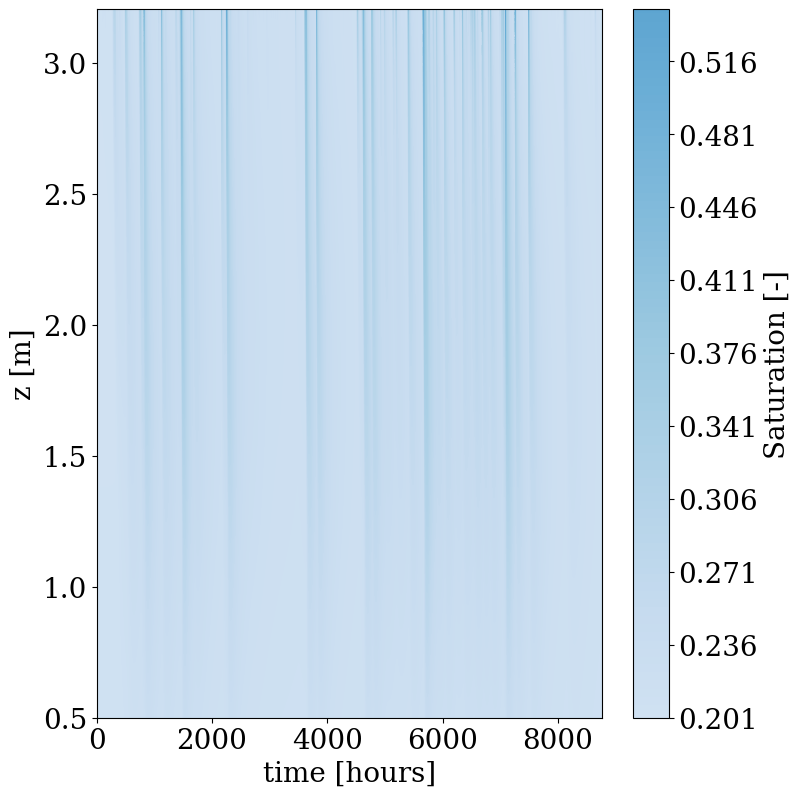

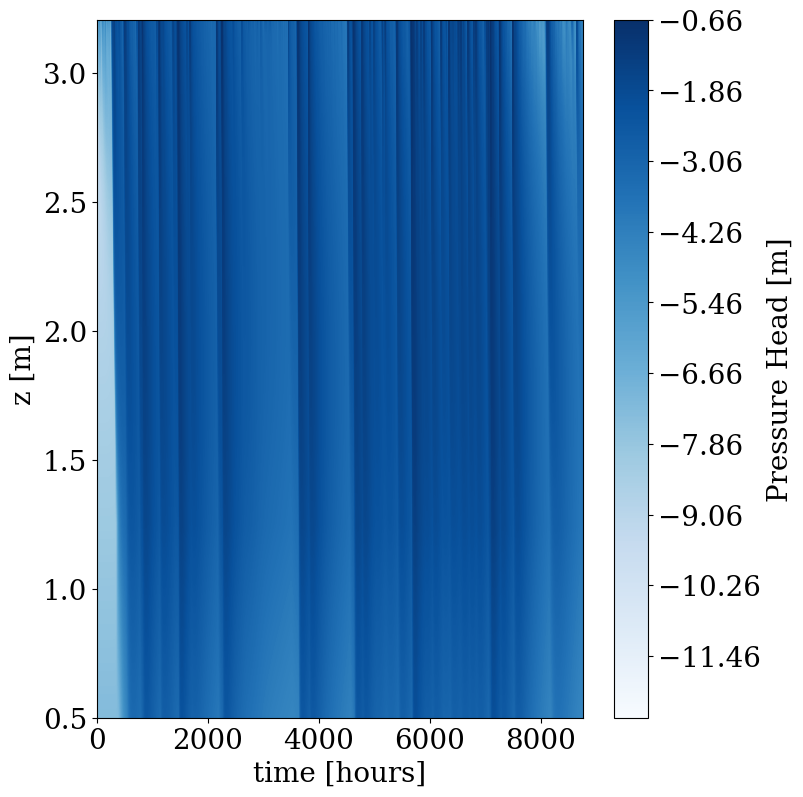

In [46]:
base = f'{path}/{run_name}'
print(base)
def plot_vert_var(base,variable, time_array,alpha_=2):
    """Function to plot output from a ParFlow run"""

    # Load the run from the file, this is the same as the run defined above
    run = Run.from_definition(f'{base}.pfidb')  

    data = run.data_accessor # get the data accessor, this makes it easier to access the data from the run
    nt = len(data.times)  # get the number of time steps
    nx = data.shape[2]    # get the number of cells in the x direction
    ny = data.shape[1]    # get the number of cells in the y direction
    nz = data.shape[0]    # get the number of cells in the z direction
    dx = data.dx          # get the cell size in the x direction
    dy = data.dy          # get the cell size in the y direction
    dz = data.dz          # get the cell size in the z direction, this is a 1D array of size nz

    # Print a summary of the run data
    #print(f"nx = {nx}, ny = {ny}, nz = {nz}, nt = {nt}")
    #print(f"dx = {dx}, dy = {dy}, dz = {dz[0]}")

    

    for timestep in time_array:
        # Load the data
        if variable == "porosity":
            data = read_pfb(get_absolute_path(f"PFCLM_SC.out.{variable}.pfb")).reshape(nz, nx)
        elif variable == "mannings":
            data = read_pfb(get_absolute_path(f"PFCLM_SC.out.mannings.pfb"))[0, :, :]
        else:
            data = read_pfb(get_absolute_path(f"PFCLM_SC.out.{variable}.{str(timestep).zfill(5)}.pfb")).reshape(nz, nx)
        
        # Set negative saturation values to NaN
        if variable == "satur":
            data[data < 0.0] = np.nan
        
        # Set up x and z to match the shape of the ParFlow grid
        x = np.arange(0.0,(nx+1)*dx,dx)
        y = np.arange(0.0,(ny+1)*dy,dy)
        z = np.zeros(nz+1)
        z[1:] = np.cumsum(dz)

        #print(f"x = {x}, y = {y}, z = {z}")
        #print(f"Shapes of : x = {x.shape}, y = {y.shape}, z = {z.shape}")

        # Get limits for plotting
        vmin = np.nanmin(data)
        vmax = np.nanmax(data)
        #print(f"vmin: {vmin}, vmax: {vmax}")
        
        # Define labels for plots
        if variable == "satur":
            label = "Saturation [-]"
            title = "Saturation [-]"
        elif variable == "press":
            label = "Pressure Head [m]"
            title = "Pressure Head [m]"
        elif variable == "porosity":
            label = "Porosity"
            title = "Porosity"
        elif variable == "mannings":
            label = "Mannings"
            title = "Mannings"

        #print(data.shape)

        if timestep ==0:
            data_array = data
        else:
            data_array = np.concatenate((data_array,data),axis=1 )

    z_mid = np.transpose(np.array([z[1:]-dz/2]))

    z_array = np.kron(np.ones(len(time_array)),z_mid)
    time_array_plot = np.kron(np.ones(z_mid.shape),np.array([time_array]))

    #print('Size: z',z.shape, 'time_array', time_array)
    #print('Size: z_array-',z_array.shape,'time_array', time_array_plot.shape,'data_array', data_array.shape)
    # Use pcolormesh to plot the data with the x and z coordinates with lines 
    # for the grid mesh from the ParFlow run grid

    #im = ax.pcolormesh(x, y, data, vmin=vmin, vmax=vmax, cmap='plasma_r')
    fig = plt.figure(figsize=(8,8) , dpi=100)
    #im = plt.plot(data,z[1:]-dz/2)#Plotting at cell centers
    if variable == "satur":
        im = plt.contourf(time_array_plot,z_array,data_array,400, cmap='Blues',vmin=0,vmax=1.0)
    else:
        im = plt.contourf(time_array_plot,z_array,data_array,400, cmap='Blues')        
    plt.xlabel(f"time [hours]")
    cbar = fig.colorbar(im)    
    cbar.ax.set_ylabel(f"{title}")
    plt.ylabel('z [m]')
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    plt.legend(loc='best', frameon=False)
    if simulation_type == 'same_saturation' or simulation_type == 'vegpvegm':
        np.savez(f'{simulation_type}_{variable}_contour_alpha{alpha_}_WTD_{head_table}',time_array_plot,z_array,data_array)
        plt.savefig(f'{simulation_type}_{variable}_contour_alpha{alpha_}_depthvstime_WTD{head_table}.pdf',bbox_inches='tight', dpi = 600)
    else:
        np.savez(f'{variable}_contour_alpha{alpha_}_WTD_{head_table}',time_array_plot,z_array,data_array)  
        plt.savefig(f'{variable}_contour_alpha{alpha_}_depthvstime_WTD{head_table}.pdf',bbox_inches='tight', dpi = 600)

plot_vert_var(base, "satur", np.linspace(0,8760,8761).astype('int'),alpha_vG)
plot_vert_var(base, "press", np.linspace(0,8760,8761).astype('int'),alpha_vG)

Time: min 0.0 max: 8760.0 z: min 0.5 max: 3.2050000000000014 Pressure: min -1.1017093915491094 max: 1.7205039659323131


/tmp/ipykernel_548251/4234672972.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best', frameon=False)
/tmp/ipykernel_548251/4234672972.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best', frameon=False)


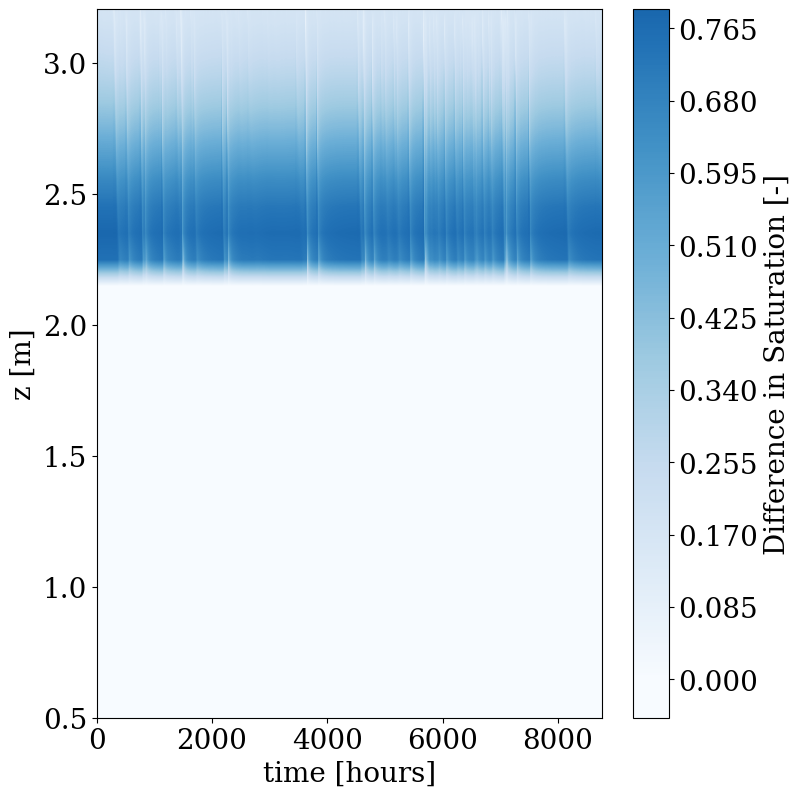

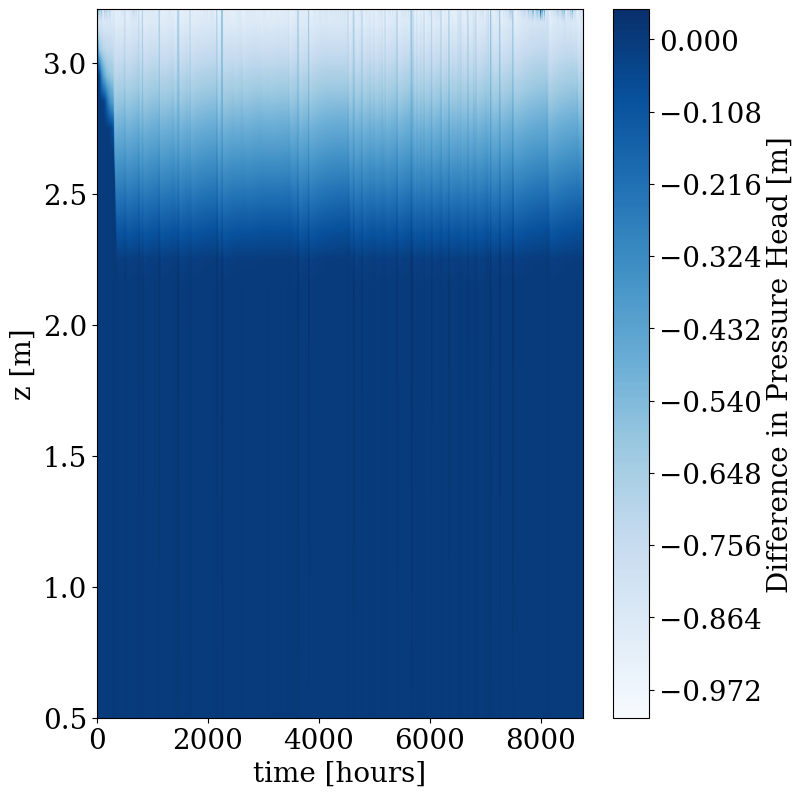

In [32]:
#Compare the two contours
#WTD = -1m
data = np.load('press_contour_alpha2_WTD_-1.npz')
#print(data)
time_array_plot = data['arr_0']; z_array = data['arr_1']; press2_data_array = data['arr_2']
print('Time: min',np.min(time_array_plot), 'max:',np.max(time_array_plot), 'z: min',np.min(z_array), 'max:',np.max(z_array), 'Pressure: min',np.min(press2_data_array), 'max:',np.max(press2_data_array) )
# plt.figure()
# plt.contourf(time_array_plot,z_array,press2_data_array,400, cmap='Blues',vmin=0,vmax=1.0)
# plt.colorbar()
# plt.show
data = np.load('satur_contour_alpha2_WTD_-1.npz');   satur2_data_array   = data['arr_2']
data = np.load('press_contour_alpha100_WTD_-1.npz'); press100_data_array = data['arr_2']
data = np.load('satur_contour_alpha100_WTD_-1.npz'); satur100_data_array = data['arr_2']

variable_array = ["satur","press"] #satur or press

for variable in variable_array:
    fig = plt.figure(figsize=(8,8) , dpi=100)
    if variable == "satur":
        label = "Saturation [-]"
        title = "Saturation [-]"
    elif variable == "press":
        label = "Pressure Head [m]"
        title = "Pressure Head [m]"
    elif variable == "porosity":
        label = "Porosity"
        title = "Porosity"
    elif variable == "mannings":
        label = "Mannings"
        title = "Mannings"

    if variable == "satur":
        im = plt.contourf(time_array_plot,z_array,satur2_data_array-satur100_data_array,400, cmap='Blues',vmin=0,vmax=1.0)
    else:
        im = plt.contourf(time_array_plot,z_array,press2_data_array-press100_data_array,400, cmap='Blues')        
    plt.xlabel(f"time [hours]")
    cbar = fig.colorbar(im)

    cbar.ax.set_ylabel(f"Difference in {title}")
    plt.ylabel('z [m]')
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    plt.legend(loc='best', frameon=False)
    plt.savefig(f'{variable}_contour_difference_depthvstime_WTD-1_alpha_2_100.pdf',bbox_inches='tight', dpi = 600)       

Time: min 0.0 max: 8760.0 z: min 0.5 max: 3.2050000000000014 Pressure: min -12.495303770656548 max: -0.6880098672943042


/tmp/ipykernel_548251/2705306681.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best', frameon=False)
/tmp/ipykernel_548251/2705306681.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best', frameon=False)


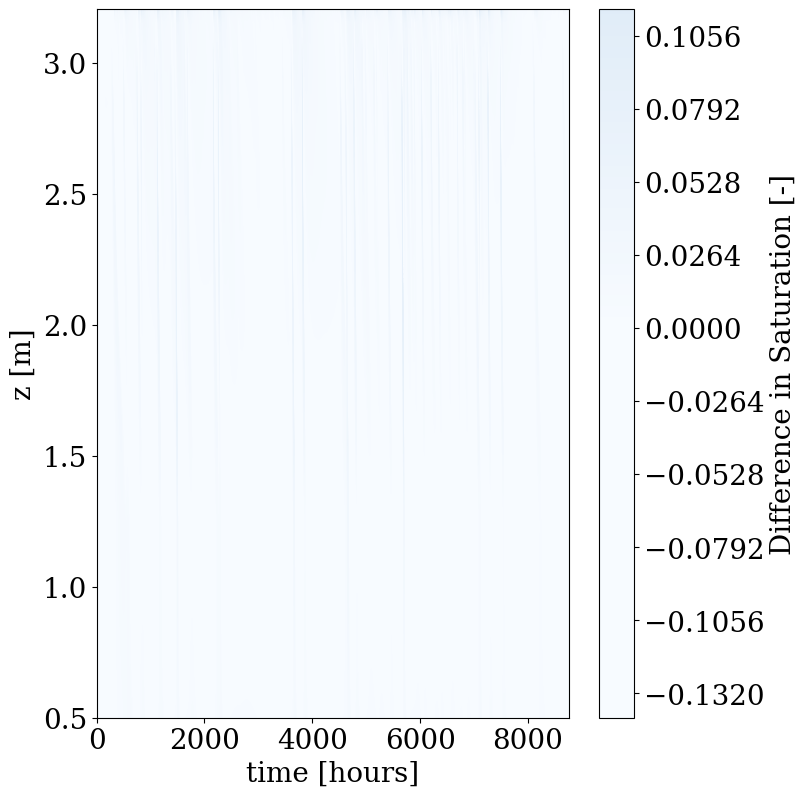

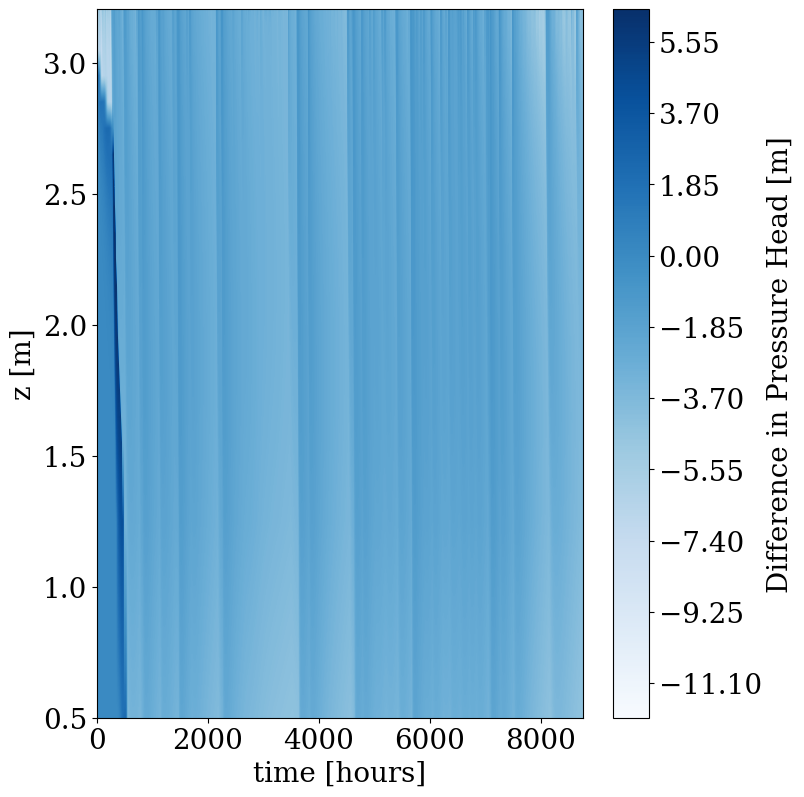

In [47]:
#Compare the two contours
#WTD = -10m
data = np.load('press_contour_alpha2_WTD_-10.npz')
#print(data)
time_array_plot = data['arr_0']; z_array = data['arr_1']; press2_data_array = data['arr_2']
print('Time: min',np.min(time_array_plot), 'max:',np.max(time_array_plot), 'z: min',np.min(z_array), 'max:',np.max(z_array), 'Pressure: min',np.min(press2_data_array), 'max:',np.max(press2_data_array) )
# plt.figure()
# plt.contourf(time_array_plot,z_array,press2_data_array,400, cmap='Blues',vmin=0,vmax=1.0)
# plt.colorbar()
# plt.show
data = np.load('satur_contour_alpha2_WTD_-10.npz');   satur2_data_array   = data['arr_2']
data = np.load('press_contour_alpha100_WTD_-10.npz'); press100_data_array = data['arr_2']
data = np.load('satur_contour_alpha100_WTD_-10.npz'); satur100_data_array = data['arr_2']

variable_array = ["satur","press"] #satur or press

for variable in variable_array:
    fig = plt.figure(figsize=(8,8) , dpi=100)
    if variable == "satur":
        label = "Saturation [-]"
        title = "Saturation [-]"
    elif variable == "press":
        label = "Pressure Head [m]"
        title = "Pressure Head [m]"
    elif variable == "porosity":
        label = "Porosity"
        title = "Porosity"
    elif variable == "mannings":
        label = "Mannings"
        title = "Mannings"

    if variable == "satur":
        im = plt.contourf(time_array_plot,z_array,satur2_data_array-satur100_data_array,400, cmap='Blues',vmin=0,vmax=1.0)
    else:
        im = plt.contourf(time_array_plot,z_array,press2_data_array-press100_data_array,400, cmap='Blues')        
    plt.xlabel(f"time [hours]")
    cbar = fig.colorbar(im)

    cbar.ax.set_ylabel(f"Difference in {title}")
    plt.ylabel('z [m]')
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    plt.legend(loc='best', frameon=False)
    plt.savefig(f'{variable}_contour_difference_depthvstime_WTD-10_alpha_2_100.pdf',bbox_inches='tight', dpi = 600)       

Time: min 0.0 max: 8760.0 z: min 0.5 max: 3.2050000000000014 Pressure: min -99.995 max: -0.6882001394171773


/tmp/ipykernel_548251/3382118295.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best', frameon=False)
/tmp/ipykernel_548251/3382118295.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best', frameon=False)


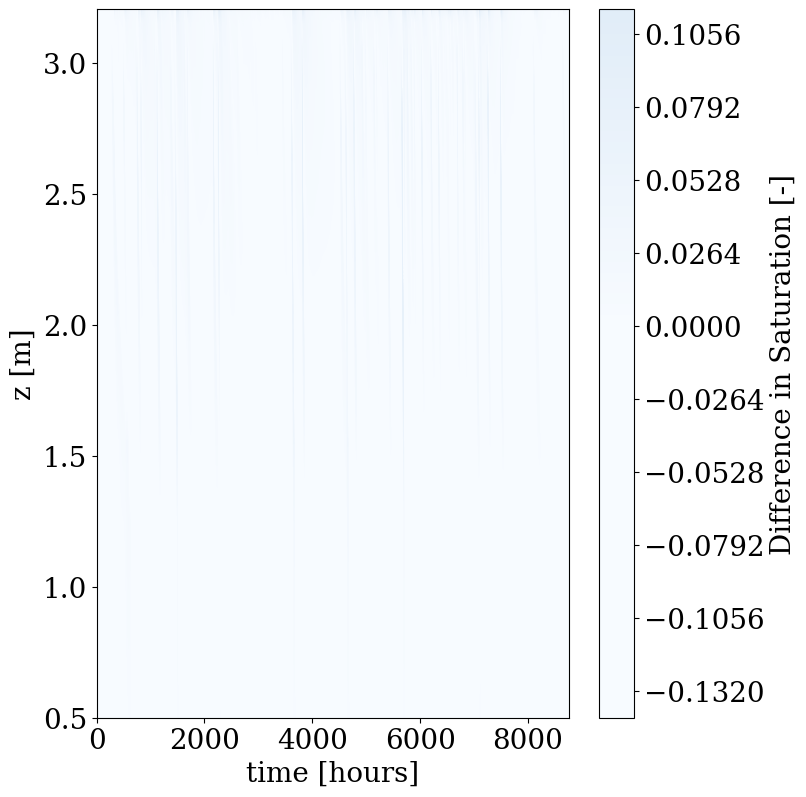

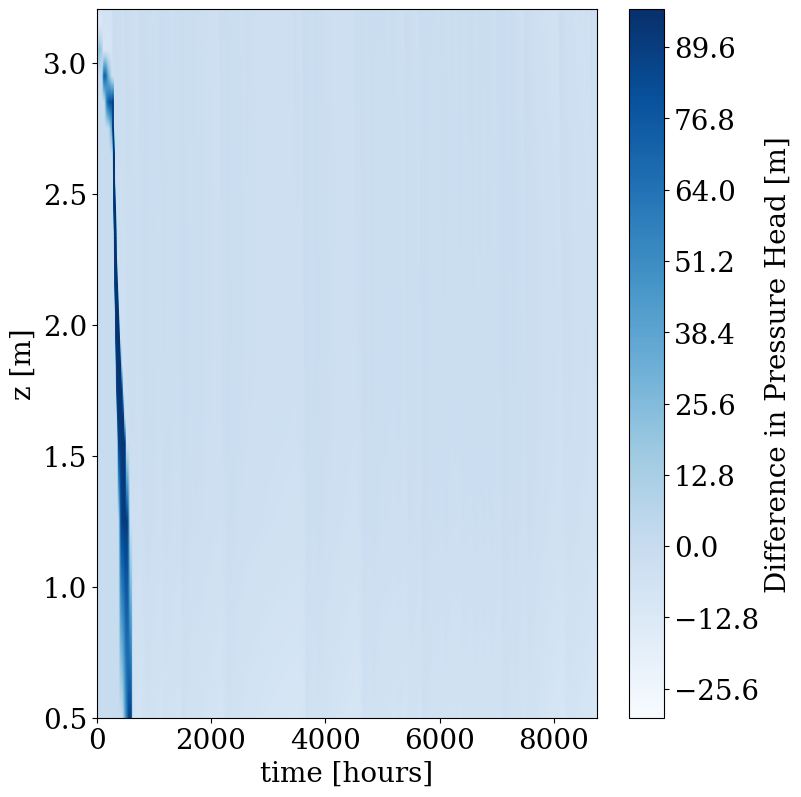

In [21]:
#Compare the two contours
#WTD = -100m
data = np.load('press_contour_alpha2_WTD_-100.npz')
#print(data)
time_array_plot = data['arr_0']; z_array = data['arr_1']; press2_data_array = data['arr_2']
print('Time: min',np.min(time_array_plot), 'max:',np.max(time_array_plot), 'z: min',np.min(z_array), 'max:',np.max(z_array), 'Pressure: min',np.min(press2_data_array), 'max:',np.max(press2_data_array) )
# plt.figure()
# plt.contourf(time_array_plot,z_array,press2_data_array,400, cmap='Blues',vmin=0,vmax=1.0)
# plt.colorbar()
# plt.show
data = np.load('satur_contour_alpha2_WTD_-100.npz');   satur2_data_array   = data['arr_2']
data = np.load('press_contour_alpha100_WTD_-100.npz'); press100_data_array = data['arr_2']
data = np.load('satur_contour_alpha100_WTD_-100.npz'); satur100_data_array = data['arr_2']

variable_array = ["satur","press"] #satur or press

for variable in variable_array:
    fig = plt.figure(figsize=(8,8) , dpi=100)
    if variable == "satur":
        label = "Saturation [-]"
        title = "Saturation [-]"
    elif variable == "press":
        label = "Pressure Head [m]"
        title = "Pressure Head [m]"
    elif variable == "porosity":
        label = "Porosity"
        title = "Porosity"
    elif variable == "mannings":
        label = "Mannings"
        title = "Mannings"

    if variable == "satur":
        im = plt.contourf(time_array_plot,z_array,satur2_data_array-satur100_data_array,400, cmap='Blues',vmin=0,vmax=1.0)
    else:
        im = plt.contourf(time_array_plot,z_array,press2_data_array-press100_data_array,400, cmap='Blues')        
    plt.xlabel(f"time [hours]")
    cbar = fig.colorbar(im)

    cbar.ax.set_ylabel(f"Difference in {title}")
    plt.ylabel('z [m]')
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    plt.legend(loc='best', frameon=False)
    plt.savefig(f'{variable}_contour_difference_depthvstime_WTD-100_alpha_2_100.pdf',bbox_inches='tight', dpi = 600)

Time: min 0.0 max: 8760.0 z: min 0.5 max: 3.2050000000000014 Pressure: min -1.025612682730018 max: 1.7368070200954233


/tmp/ipykernel_548251/2464772428.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best', frameon=False)
/tmp/ipykernel_548251/2464772428.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best', frameon=False)


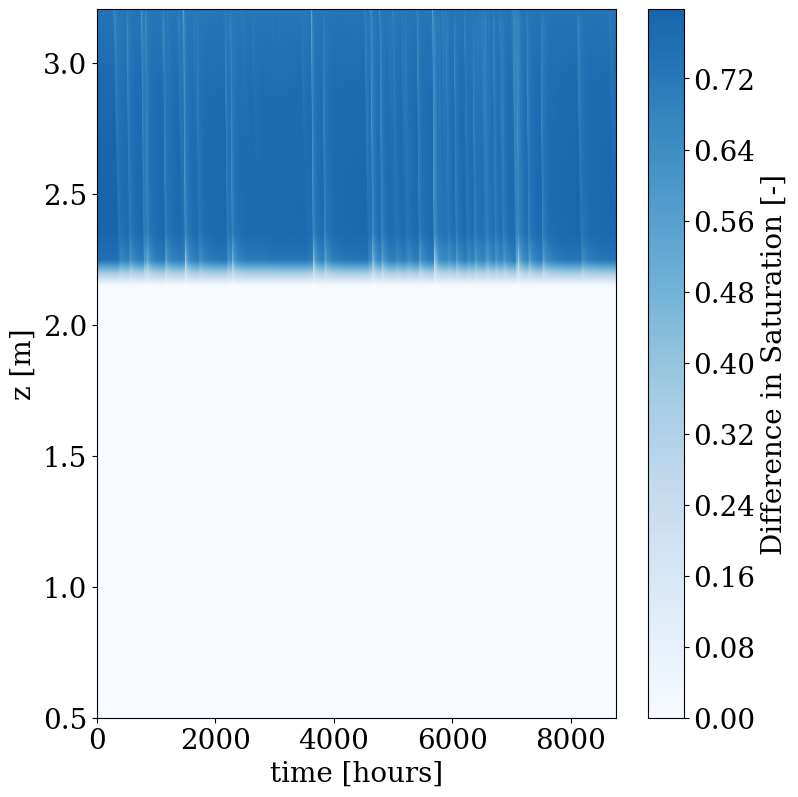

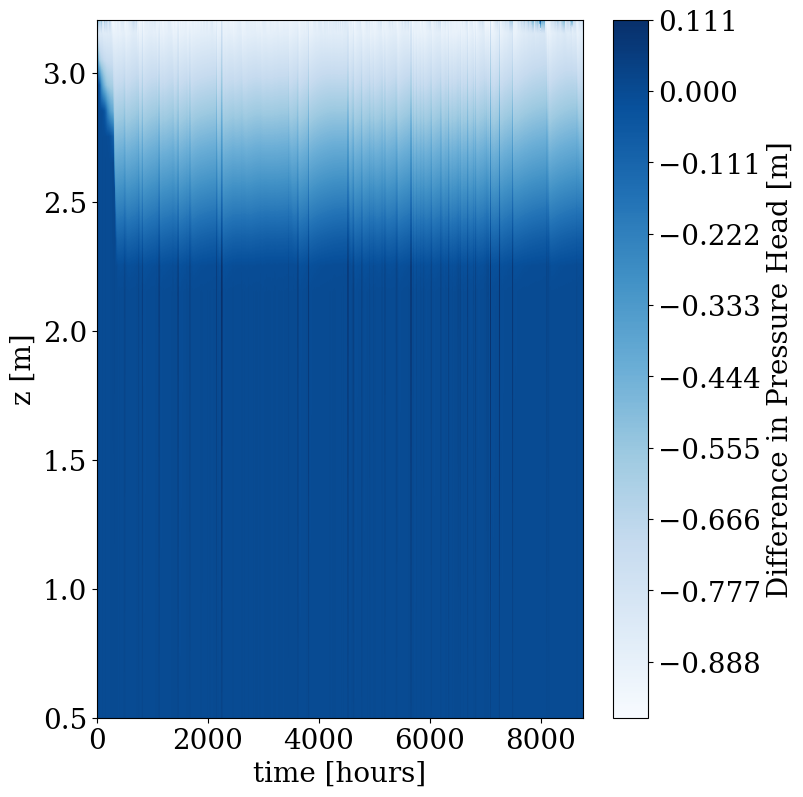

In [33]:
#Compare against alpha=0.5
#Compare the two contours
#WTD = -1m
data = np.load('press_contour_alpha0.5_WTD_-1.npz')
#print(data)
time_array_plot = data['arr_0']; z_array = data['arr_1']; press2_data_array = data['arr_2']
print('Time: min',np.min(time_array_plot), 'max:',np.max(time_array_plot), 'z: min',np.min(z_array), 'max:',np.max(z_array), 'Pressure: min',np.min(press2_data_array), 'max:',np.max(press2_data_array) )
# plt.figure()
# plt.contourf(time_array_plot,z_array,press2_data_array,400, cmap='Blues',vmin=0,vmax=1.0)
# plt.colorbar()
# plt.show
data = np.load('satur_contour_alpha0.5_WTD_-1.npz');   satur2_data_array = data['arr_2']
data = np.load('press_contour_alpha100_WTD_-1.npz'); press100_data_array = data['arr_2']
data = np.load('satur_contour_alpha100_WTD_-1.npz'); satur100_data_array = data['arr_2']

variable_array = ["satur","press"] #satur or press

for variable in variable_array:
    fig = plt.figure(figsize=(8,8) , dpi=100)
    if variable == "satur":
        label = "Saturation [-]"
        title = "Saturation [-]"
    elif variable == "press":
        label = "Pressure Head [m]"
        title = "Pressure Head [m]"
    elif variable == "porosity":
        label = "Porosity"
        title = "Porosity"
    elif variable == "mannings":
        label = "Mannings"
        title = "Mannings"

    if variable == "satur":
        im = plt.contourf(time_array_plot,z_array,satur2_data_array-satur100_data_array,400, cmap='Blues',vmin=0,vmax=1.0)
    else:
        im = plt.contourf(time_array_plot,z_array,press2_data_array-press100_data_array,400, cmap='Blues')        
    plt.xlabel(f"time [hours]")
    cbar = fig.colorbar(im)

    cbar.ax.set_ylabel(f"Difference in {title}")
    plt.ylabel('z [m]')
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    plt.legend(loc='best', frameon=False)
    plt.savefig(f'{variable}_contour_difference_alpha0.5_depthvstime_WTD-1_alpha_0.5_100.pdf',bbox_inches='tight', dpi = 600)

Time: min 0.0 max: 8760.0 z: min 0.5 max: 3.2050000000000014 Pressure: min -99.995 max: -3.3265891960059917


/tmp/ipykernel_548251/117207782.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best', frameon=False)
/tmp/ipykernel_548251/117207782.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best', frameon=False)


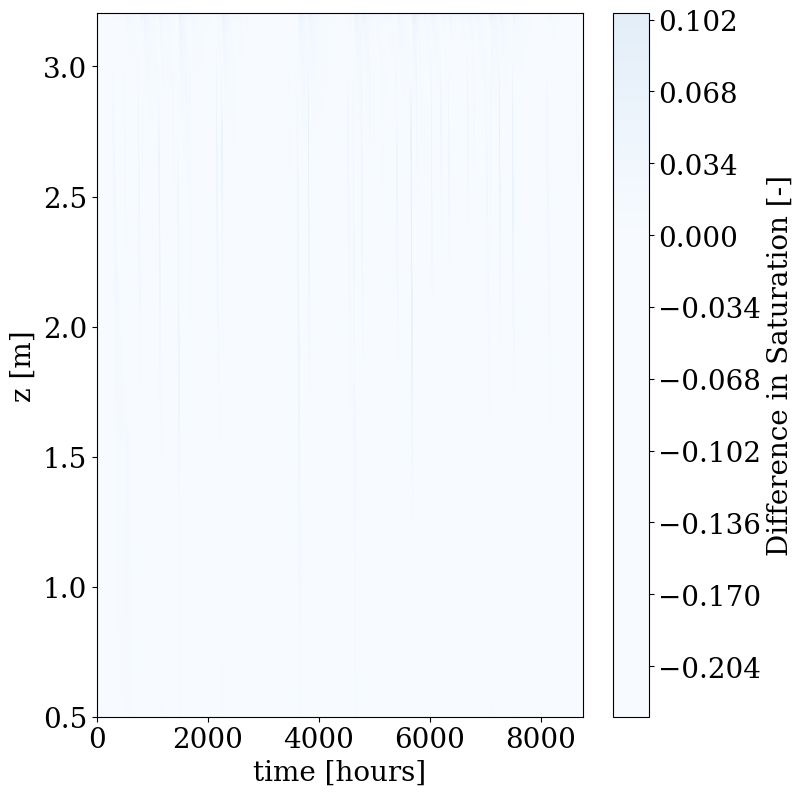

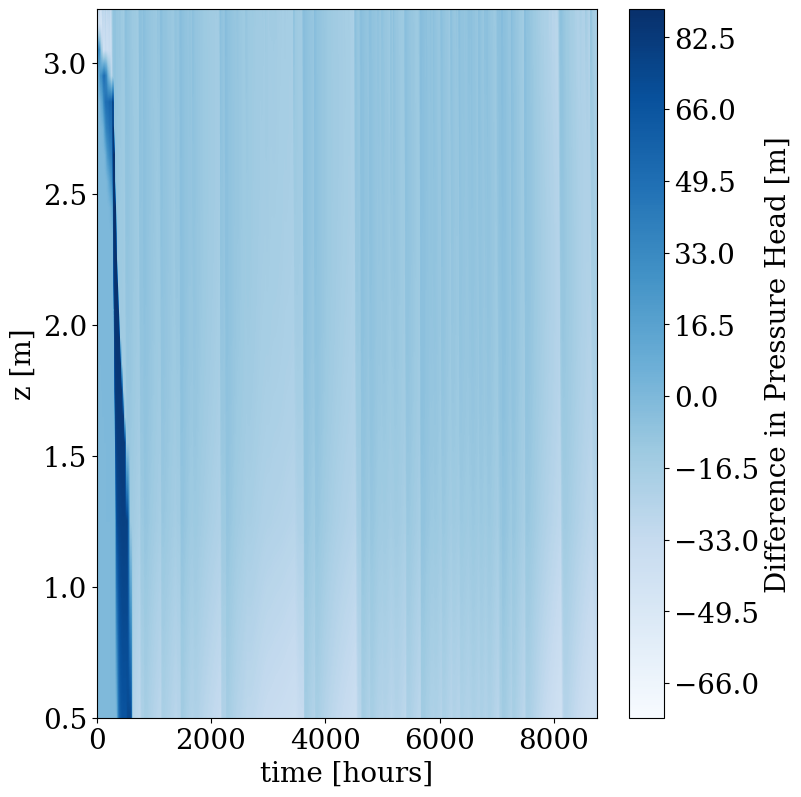

In [34]:
#Compare the two contours
#WTD = -100m
data = np.load('press_contour_alpha0.5_WTD_-100.npz')
#print(data)
time_array_plot = data['arr_0']; z_array = data['arr_1']; press2_data_array = data['arr_2']
print('Time: min',np.min(time_array_plot), 'max:',np.max(time_array_plot), 'z: min',np.min(z_array), 'max:',np.max(z_array), 'Pressure: min',np.min(press2_data_array), 'max:',np.max(press2_data_array) )
# plt.figure()
# plt.contourf(time_array_plot,z_array,press2_data_array,400, cmap='Blues',vmin=0,vmax=1.0)
# plt.colorbar()
# plt.show
data = np.load('satur_contour_alpha0.5_WTD_-100.npz');   satur2_data_array = data['arr_2']
data = np.load('press_contour_alpha100_WTD_-100.npz'); press100_data_array = data['arr_2']
data = np.load('satur_contour_alpha100_WTD_-100.npz'); satur100_data_array = data['arr_2']

variable_array = ["satur","press"] #satur or press

for variable in variable_array:
    fig = plt.figure(figsize=(8,8) , dpi=100)
    if variable == "satur":
        label = "Saturation [-]"
        title = "Saturation [-]"
    elif variable == "press":
        label = "Pressure Head [m]"
        title = "Pressure Head [m]"
    elif variable == "porosity":
        label = "Porosity"
        title = "Porosity"
    elif variable == "mannings":
        label = "Mannings"
        title = "Mannings"

    if variable == "satur":
        im = plt.contourf(time_array_plot,z_array,satur2_data_array-satur100_data_array,400, cmap='Blues',vmin=0,vmax=1.0)
    else:
        im = plt.contourf(time_array_plot,z_array,press2_data_array-press100_data_array,400, cmap='Blues')        
    plt.xlabel(f"time [hours]")
    cbar = fig.colorbar(im)

    cbar.ax.set_ylabel(f"Difference in {title}")
    plt.ylabel('z [m]')
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    plt.legend(loc='best', frameon=False)
    plt.savefig(f'{variable}_contour_difference_depthvstime_WTD-100_alpha_0.5_100.pdf',bbox_inches='tight', dpi = 600)

Time: min 0.0 max: 8760.0 z: min 0.5 max: 3.2050000000000014 Pressure: min -6.7563599193813095 max: 1.709999999999996


/tmp/ipykernel_1106582/2129223770.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best', frameon=False)
/tmp/ipykernel_1106582/2129223770.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best', frameon=False)


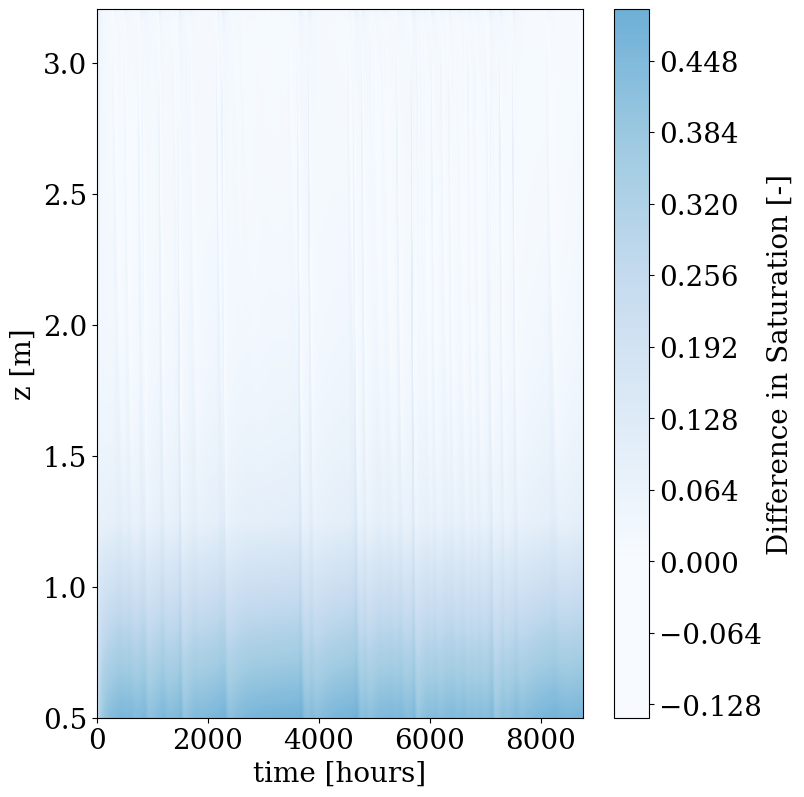

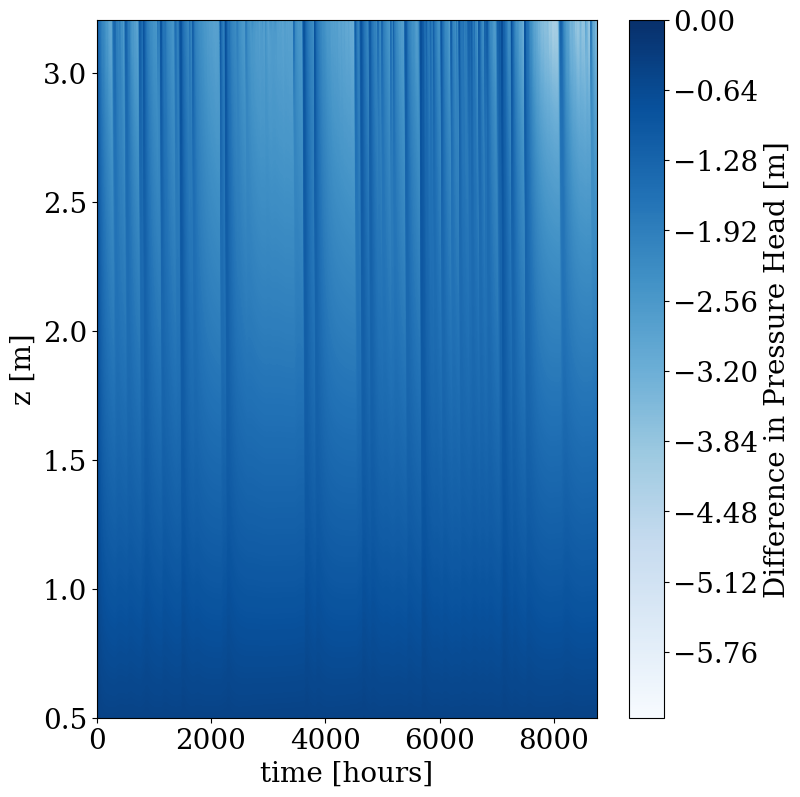

In [3]:
#Same initial saturation
#Compare the two contours
#WTD = -1m
data = np.load('same_saturation_press_contour_alpha2_WTD_-1.npz')
#print(data)
time_array_plot = data['arr_0']; z_array = data['arr_1']; press2_data_array = data['arr_2']
print('Time: min',np.min(time_array_plot), 'max:',np.max(time_array_plot), 'z: min',np.min(z_array), 'max:',np.max(z_array), 'Pressure: min',np.min(press2_data_array), 'max:',np.max(press2_data_array) )
# plt.figure()
# plt.contourf(time_array_plot,z_array,press2_data_array,400, cmap='Blues',vmin=0,vmax=1.0)
# plt.colorbar()
# plt.show
data = np.load('same_saturation_satur_contour_alpha2_WTD_-1.npz');   satur2_data_array   = data['arr_2']
data = np.load('same_saturation_press_contour_alpha100_WTD_-1.npz'); press100_data_array = data['arr_2']
data = np.load('same_saturation_satur_contour_alpha100_WTD_-1.npz'); satur100_data_array = data['arr_2']

variable_array = ["satur","press"] #satur or press

for variable in variable_array:
    fig = plt.figure(figsize=(8,8) , dpi=100)
    if variable == "satur":
        label = "Saturation [-]"
        title = "Saturation [-]"
    elif variable == "press":
        label = "Pressure Head [m]"
        title = "Pressure Head [m]"
    elif variable == "porosity":
        label = "Porosity"
        title = "Porosity"
    elif variable == "mannings":
        label = "Mannings"
        title = "Mannings"

    if variable == "satur":
        im = plt.contourf(time_array_plot,z_array,satur2_data_array-satur100_data_array,400, cmap='Blues',vmin=0,vmax=1.0)
    else:
        im = plt.contourf(time_array_plot,z_array,press2_data_array-press100_data_array,400, cmap='Blues')        
    plt.xlabel(f"time [hours]")
    cbar = fig.colorbar(im)

    cbar.ax.set_ylabel(f"Difference in {title}")
    plt.ylabel('z [m]')
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    plt.legend(loc='best', frameon=False)
    plt.savefig(f'same_saturation_{variable}_contour_difference_depthvstime_WTD-1_alpha_2_100.pdf',bbox_inches='tight', dpi = 600)       

Time: min 0.0 max: 8760.0 z: min 0.5 max: 3.2050000000000014 Pressure: min -516.3921022693669 max: -0.4762274908084582


/tmp/ipykernel_587582/2004204893.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best', frameon=False)
/tmp/ipykernel_587582/2004204893.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best', frameon=False)


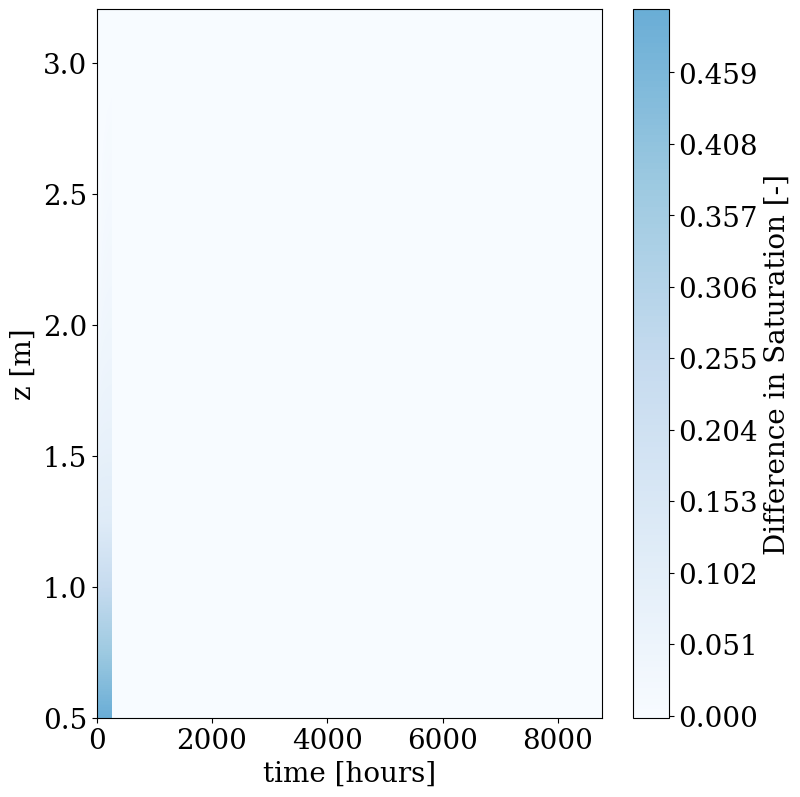

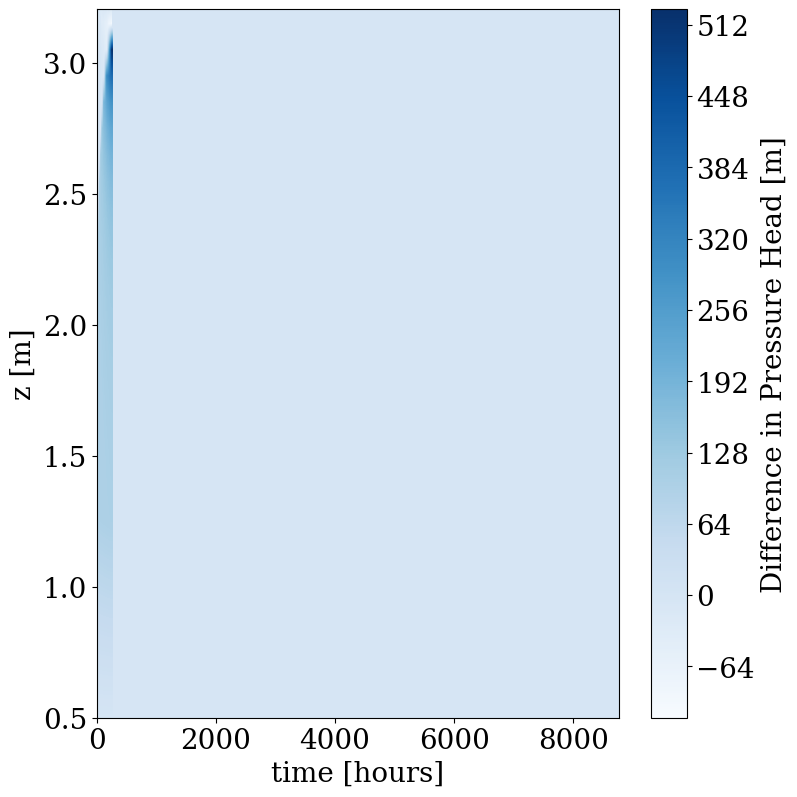

In [33]:
#Compare the two contours
#WTD = -100m for everfreen needleleaf forests
data = np.load('vegpvegm_press_contour_alpha2_WTD_-100.npz')
#print(data)
time_array_plot = data['arr_0']; z_array = data['arr_1']; press2_data_array = data['arr_2']
print('Time: min',np.min(time_array_plot), 'max:',np.max(time_array_plot), 'z: min',np.min(z_array), 'max:',np.max(z_array), 'Pressure: min',np.min(press2_data_array), 'max:',np.max(press2_data_array) )
# plt.figure()
# plt.contourf(time_array_plot,z_array,press2_data_array,400, cmap='Blues',vmin=0,vmax=1.0)
# plt.colorbar()
# plt.show
data = np.load('vegpvegm_satur_contour_alpha2_WTD_-100.npz');   satur2_data_array   = data['arr_2']
data = np.load('vegpvegm_press_contour_alpha100_WTD_-100.npz'); press100_data_array = data['arr_2']
data = np.load('vegpvegm_satur_contour_alpha100_WTD_-100.npz'); satur100_data_array = data['arr_2']

variable_array = ["satur","press"] #satur or press

for variable in variable_array:
    fig = plt.figure(figsize=(8,8) , dpi=100)
    if variable == "satur":
        label = "Saturation [-]"
        title = "Saturation [-]"
    elif variable == "press":
        label = "Pressure Head [m]"
        title = "Pressure Head [m]"
    elif variable == "porosity":
        label = "Porosity"
        title = "Porosity"
    elif variable == "mannings":
        label = "Mannings"
        title = "Mannings"

    if variable == "satur":
        im = plt.contourf(time_array_plot,z_array,satur2_data_array-satur100_data_array,400, cmap='Blues',vmin=0,vmax=1.0)
    else:
        im = plt.contourf(time_array_plot,z_array,press2_data_array-press100_data_array,400, cmap='Blues')        
    plt.xlabel(f"time [hours]")
    cbar = fig.colorbar(im)

    cbar.ax.set_ylabel(f"Difference in {title}")
    plt.ylabel('z [m]')
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    plt.legend(loc='best', frameon=False)
    plt.savefig(f'vegpvegm_{variable}_contour_difference_depthvstime_WTD-100_alpha_2_100.pdf',bbox_inches='tight', dpi = 600)